In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import math
from imutils import contours

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

sns.set(rc={'figure.figsize' : (22, 20)})
sns.set_style("darkgrid", {'axes.grid' : True})

import tensorflow as tf

In [2]:
def showImg(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [3]:
def prepareImg(img, height):
    "convert given image to grayscale image (if needed) and resize to desired height"
    assert img.ndim in (2, 3)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)

2
(1000, 750)


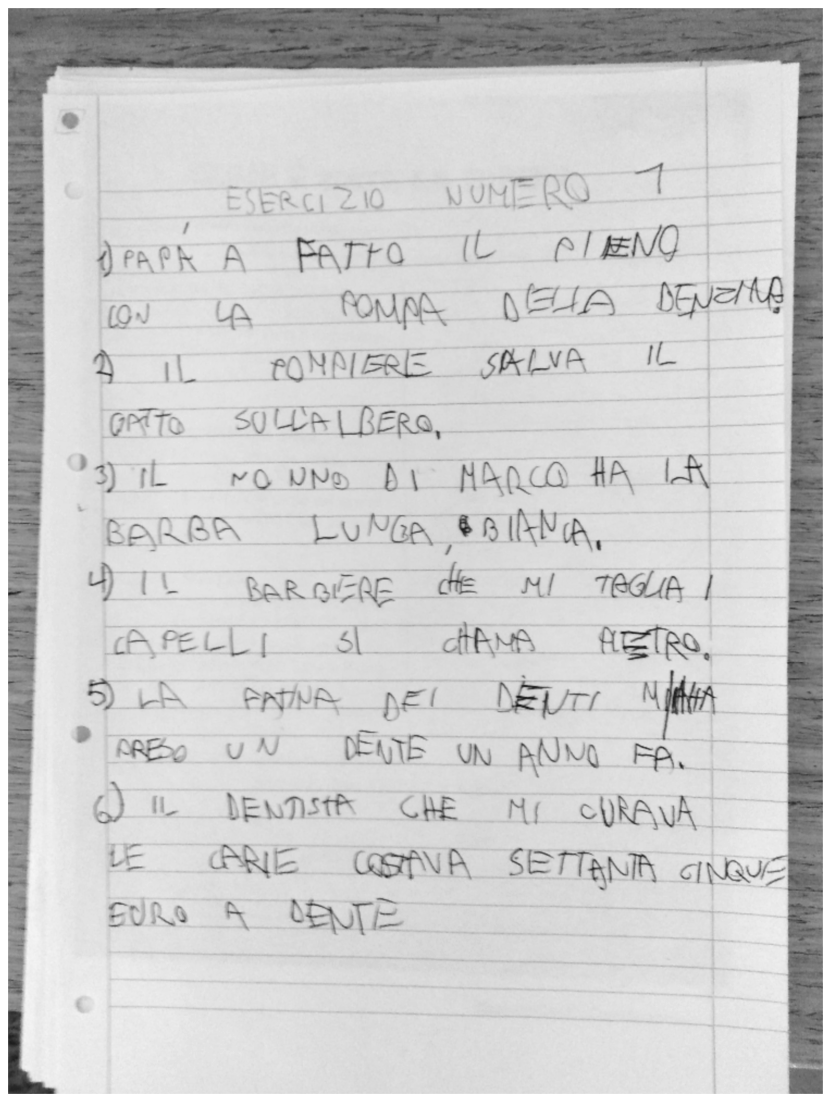

In [4]:
img = prepareImg(cv2.imread('92449806_519828068919735_7511867168997244928_n.jpg', cv2.IMREAD_GRAYSCALE), 1000)
print(img.ndim)
print(img.shape)

showImg(img, cmap='gray')

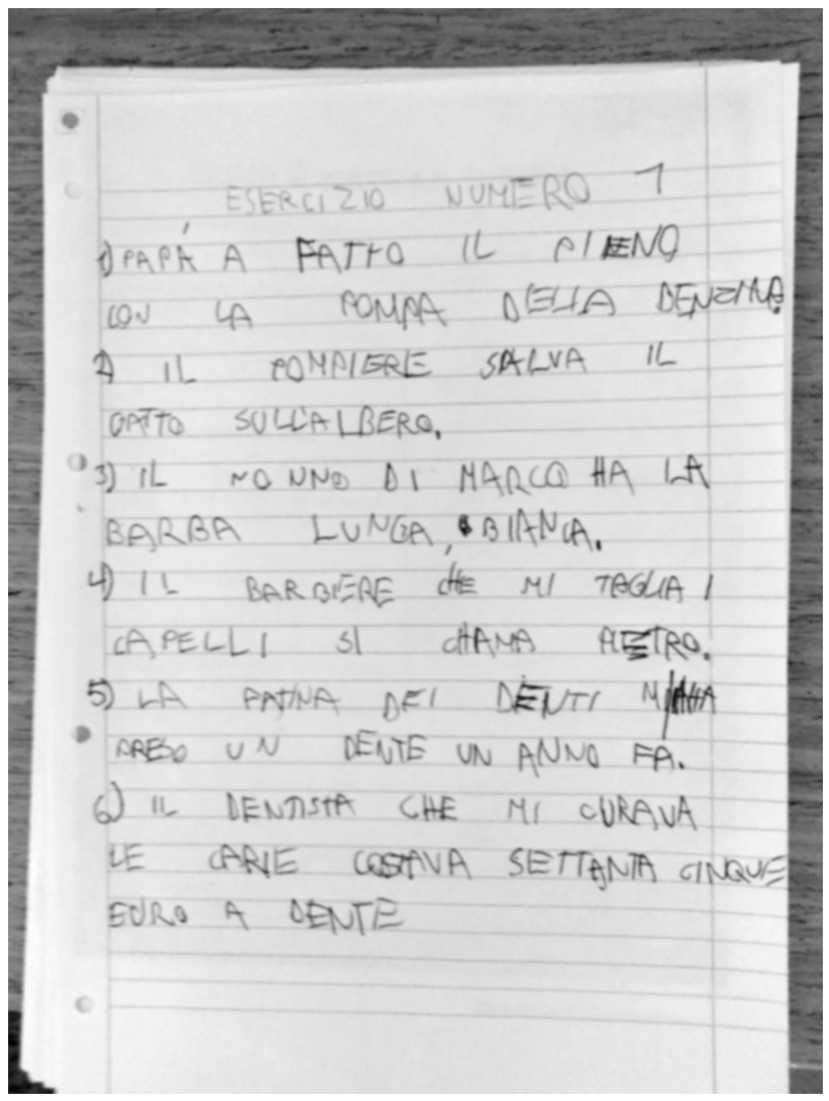

In [5]:
blur = cv2.GaussianBlur(img,(5,5),0)
showImg(blur, cmap='gray')

In [6]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
rectKernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 13))
sq1Kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
sq2Kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))

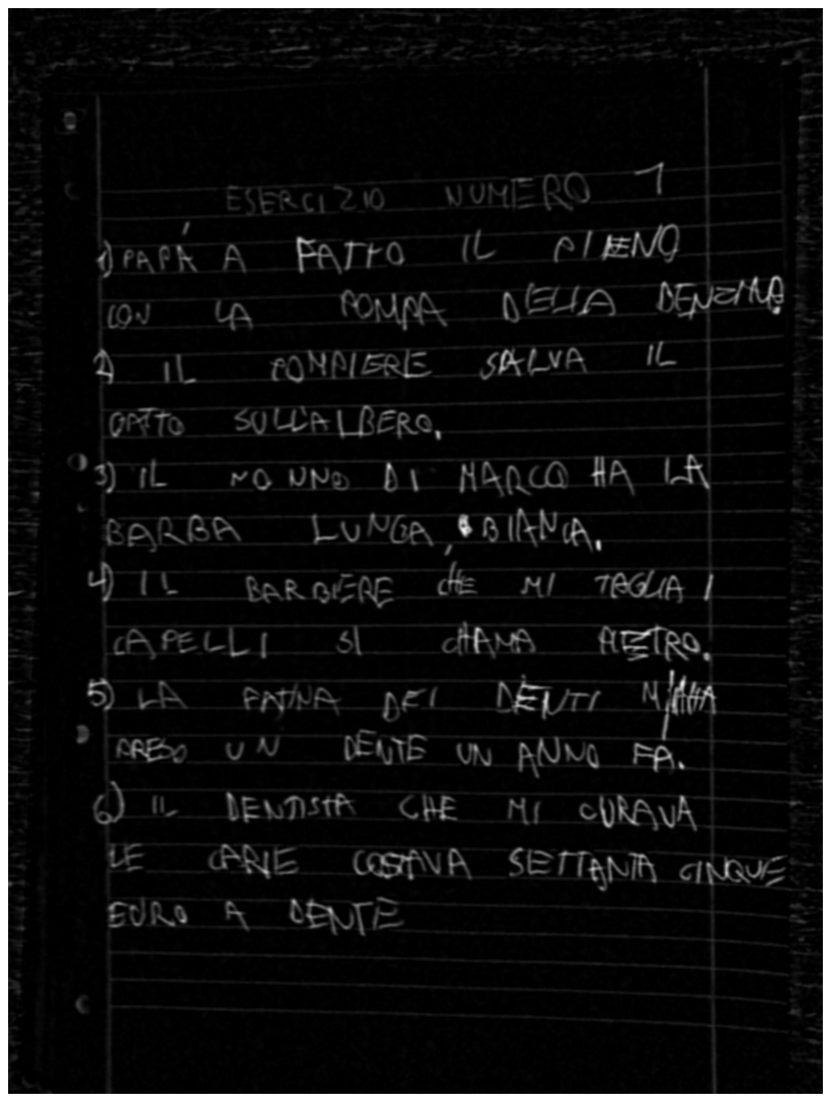

In [7]:
blackhat = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, rectKernel)
showImg(blackhat, cmap='gray')

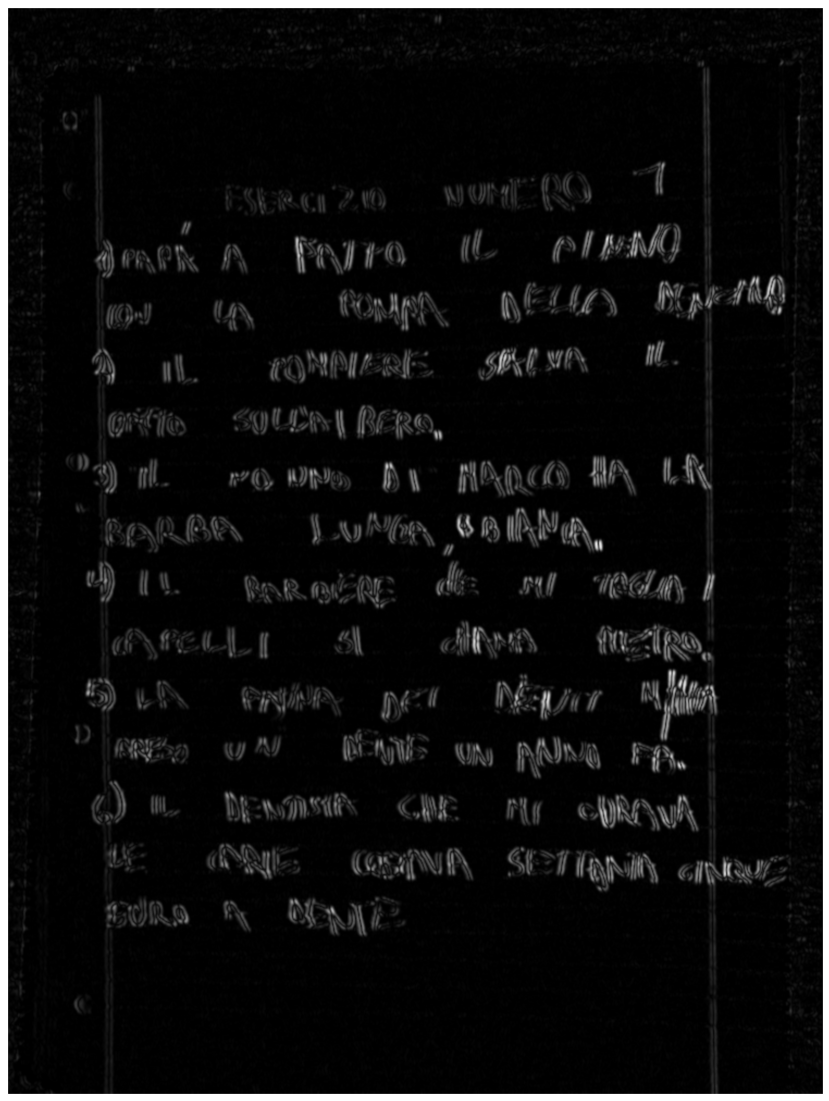

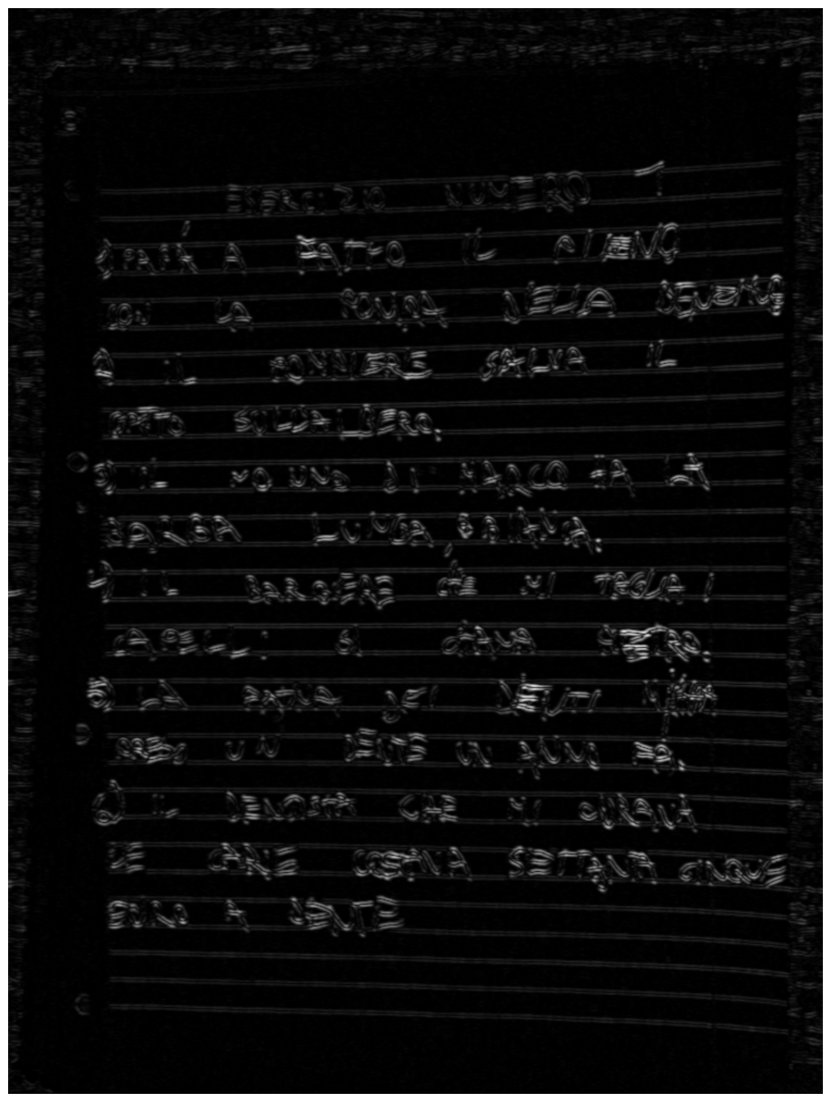

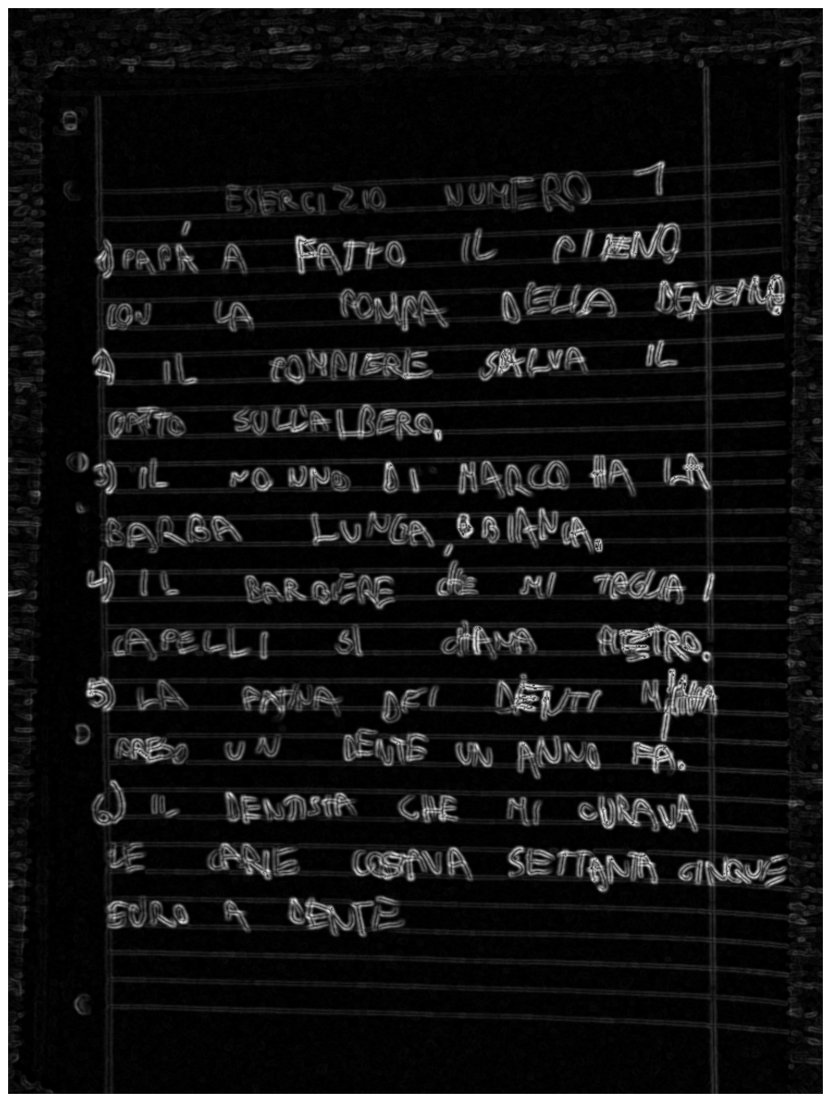

In [8]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)

# Compute the Scharr gradient along the y-axis of the blackhat image
gradY = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
gradY = np.absolute(gradY)

# We then take this gradient image and scale it back into the range [0, 255] using min/max scaling
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")

(minVal, maxVal) = (np.min(gradY), np.max(gradY))
gradY = (255 * ((gradY - minVal) / (maxVal - minVal))).astype("uint8")

showImg(gradX, cmap='gray')
showImg(gradY, cmap='gray')
showImg(gradY+gradX, cmap='gray')

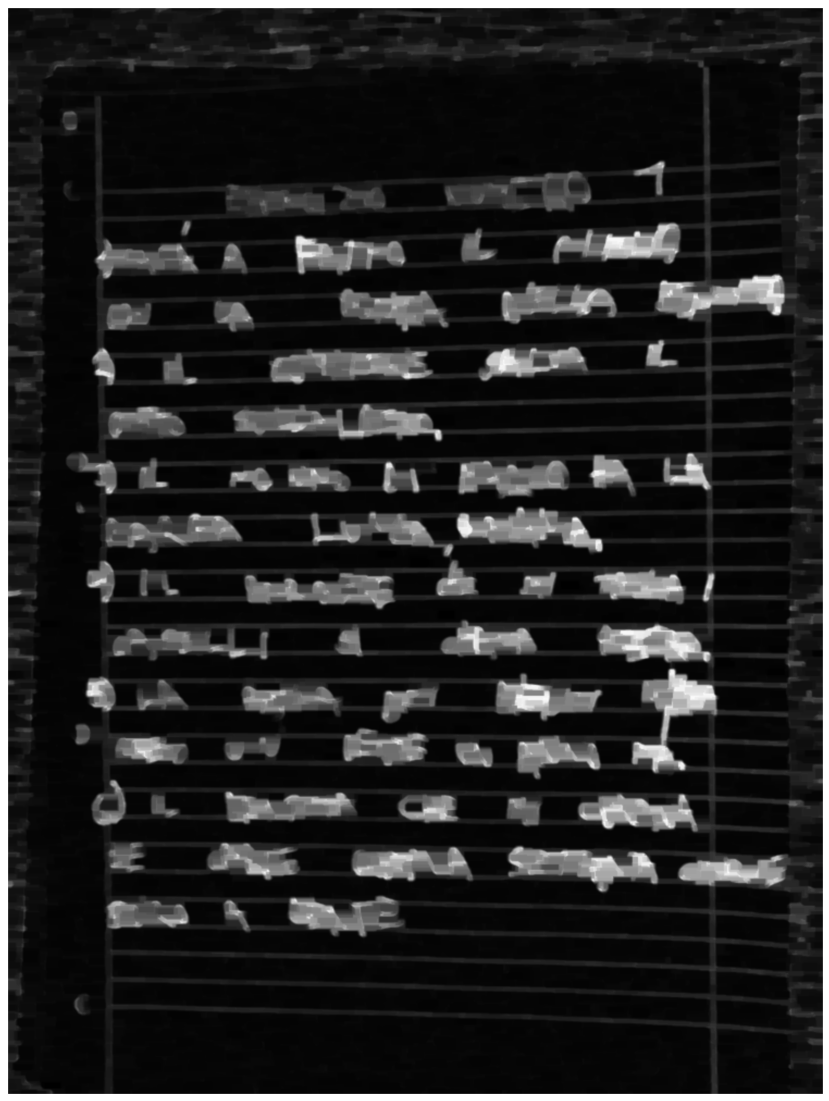

In [9]:


# Then, we apply a closing operation using our rectangular kernel. This closing operation is meant to close gaps in between characters.
close_img2 = cv2.morphologyEx(gradY+gradX, cv2.MORPH_CLOSE, rectKernel)
showImg(close_img2, cmap='gray')


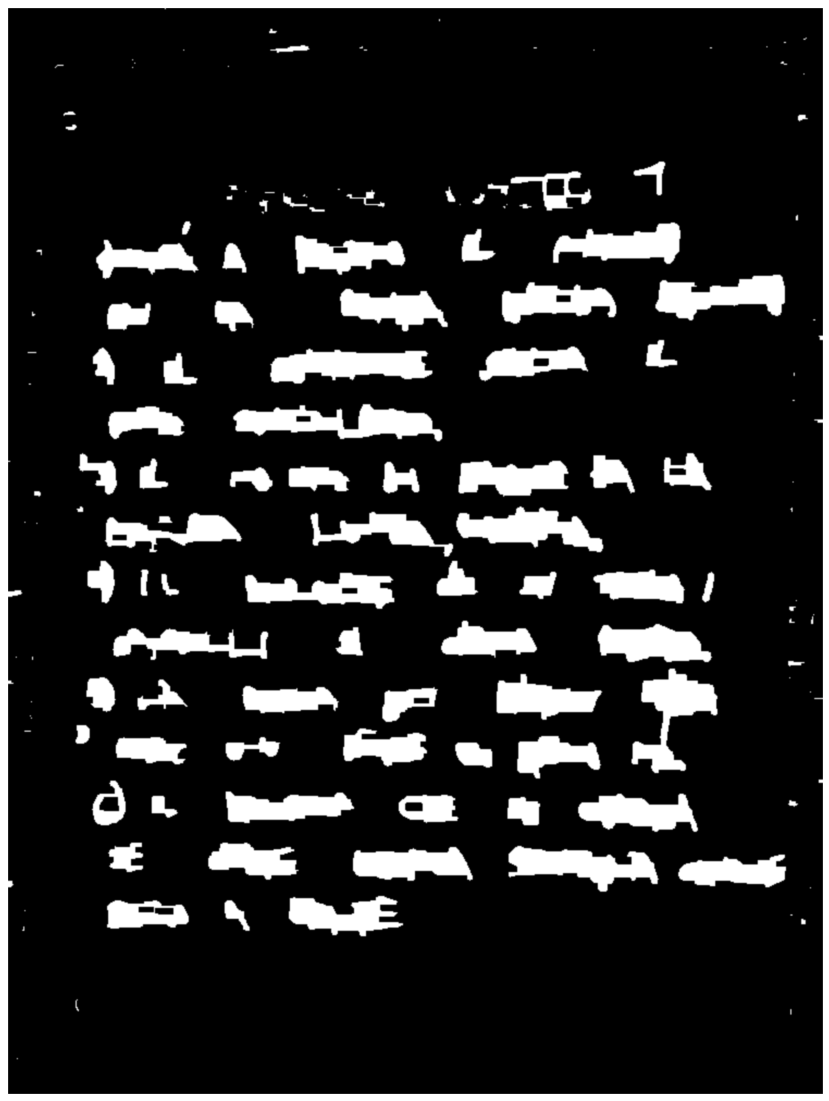

In [10]:
(_, imgThres) = cv2.threshold(close_img2, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
showImg(imgThres, cmap='gray')

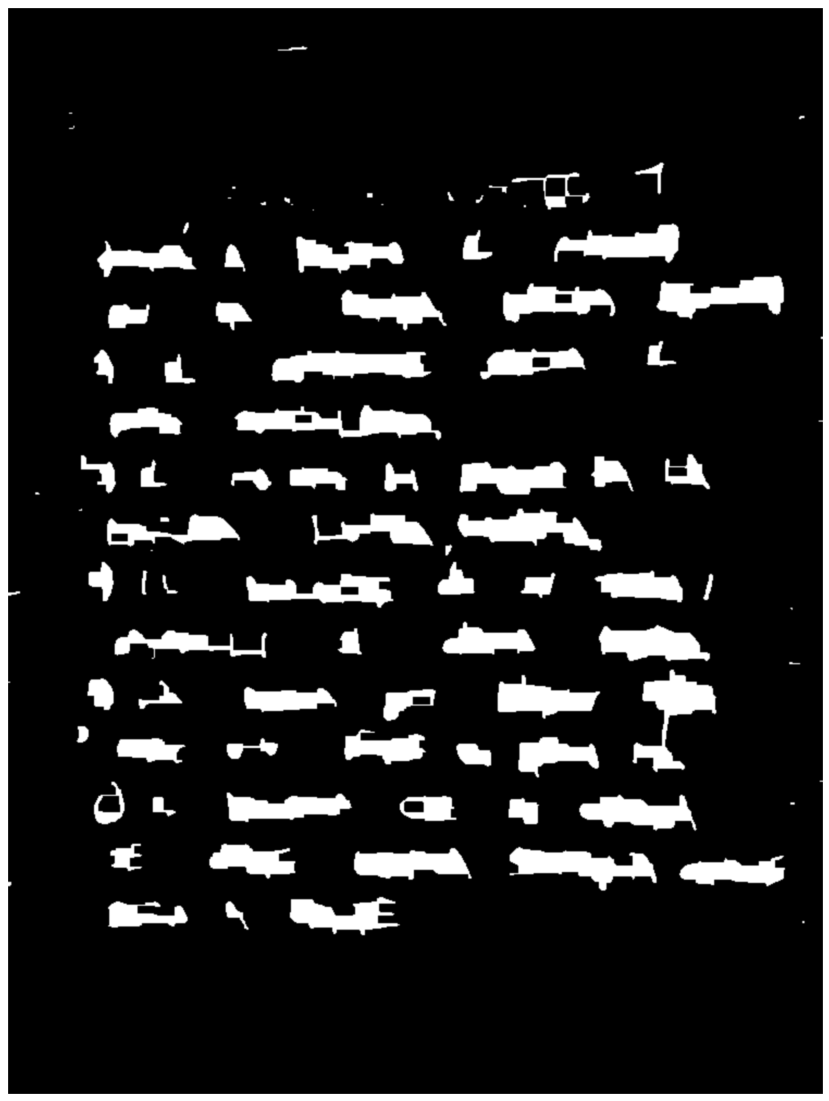

In [11]:

thresh2 = cv2.erode(imgThres, None, iterations=1)
showImg(thresh2, cmap='gray')

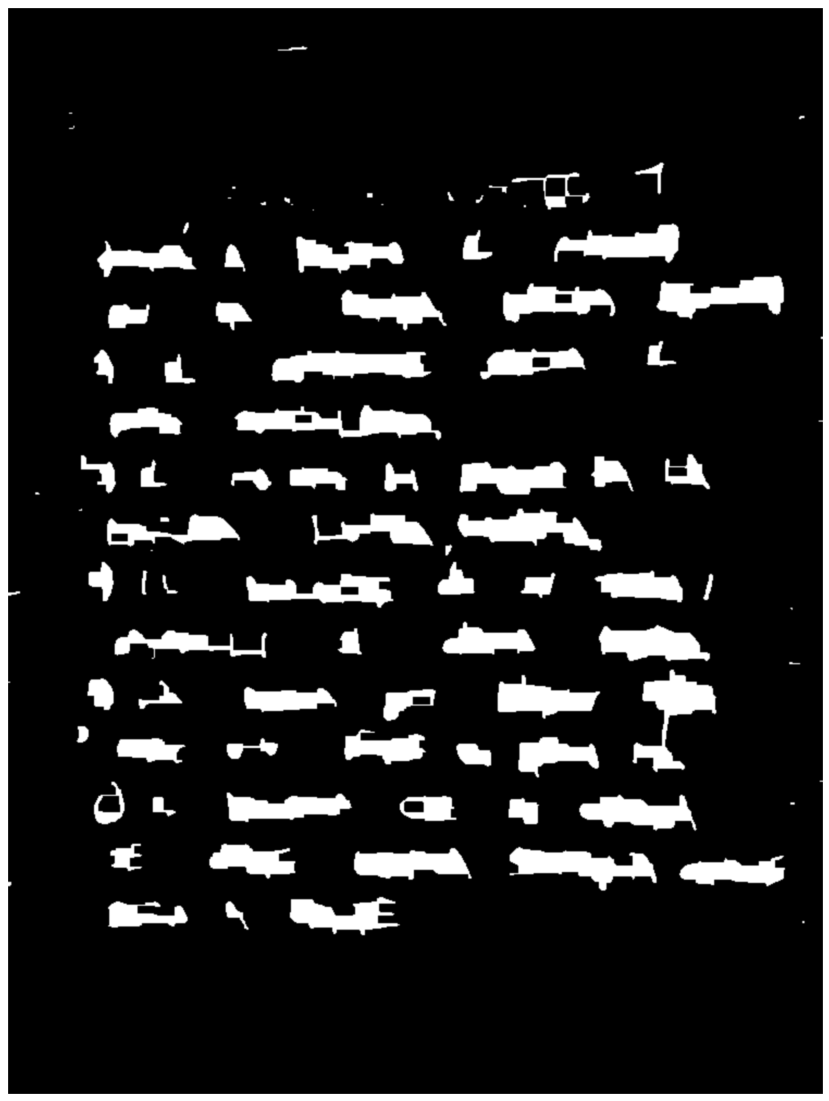

In [12]:
(_, imgThres) = cv2.threshold(thresh2, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
showImg(imgThres, cmap='gray')

In [13]:
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts


In [14]:
def display_contours(contours):
    plt.figure(figsize=(40, 40))
    for i, c in enumerate(contours):
        contour = c[1]
        plt.subplot(40, 3, i+1)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Contour #{0}, size: {1}".format(i, c[0]))
        _ = plt.imshow(contour, cmap='gray')
    plt.show()


In [15]:
components = grab_contours(cv2.findContours(imgThres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE))
minArea= 100
# append components to result
res = []
i = 0

for c in components:
    # skip small word candidates
    i += 1
    if cv2.contourArea(c) < minArea:
        continue
    # append bounding box and image of word to result list
    currBox = cv2.boundingRect(c) # returns (x, y, w, h)
    (x, y, w, h) = currBox
    
    #if h > 80:
    #    continue
    
    currImg = img[y:y+h, x:x+w]
    res.append((currBox, currImg))
    plt.imsave('seg_words/img_'+str(i)+'.png', currImg)
    #plt.figure()
    #plt.imshow(currImg)
    
print(len(res))

75


In [16]:
list1 = sorted(res, key=lambda x: x[0][1])

In [17]:
lib

In [18]:
list2[0:5]

[[((464, 153, 72, 34),
   array([[168, 166, 167, ..., 164, 161, 161],
          [166, 168, 167, ..., 152, 152, 148],
          [168, 165, 167, ..., 158, 156, 164],
          ...,
          [158, 143, 136, ..., 169, 168, 168],
          [163, 148, 142, ..., 170, 169, 170],
          [163, 154, 146, ..., 170, 173, 170]], dtype=uint8)),
  ((577, 144, 27, 29),
   array([[173, 175, 173, 172, 172, 175, 171, 174, 174, 173, 173, 173, 174,
           174, 174, 174, 173, 175, 173, 173, 173, 168, 172, 155, 107, 116,
           149],
          [175, 172, 173, 171, 170, 173, 171, 173, 171, 175, 174, 174, 174,
           174, 173, 173, 173, 174, 171, 176, 169, 159, 140,  94,  73,  85,
           162],
          [173, 172, 173, 171, 170, 175, 172, 175, 172, 173, 174, 174, 176,
           172, 173, 173, 174, 176, 172, 170, 166, 107,  89,  81,  82, 113,
           174],
          [170, 172, 174, 174, 175, 174, 171, 168, 175, 175, 176, 176, 172,
           173, 176, 172, 162, 168, 148, 106,  93, 100, 11